# Evaluate inversion results
This notebook evaluates and plots the results of the Mesa Range magnetic inversion.

jupyter notebook written by Maximilian Lowe (maxwe32@bas.ac.uk). Last update 01/02/2024

In [1]:
import numpy as np
import netCDF4 as nc4
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas as gpd
from cmcrameri import cm
from tqdm.notebook import tqdm, trange
import time  # to be used in loop iterations
import cartopy.crs as ccrs
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import glob
from PIL import Image
from scipy.interpolate import griddata

#### set inversion directory and create output directory

In [2]:
inv_run = "Mesa_range_mag_inversion_only_250m_reg10/"

export_fig_path = inv_run + "Output/Figure/"

# Create path if it does not exists
if not os.path.exists(export_fig_path):
    os.makedirs(export_fig_path)

#### set global variables 

In [3]:
unit_dens = "kg/m$^3$"
unit_sus = "SI"

cmap = cm.roma_r
cmap_rev = cm.roma_r
cmap_diff = cm.vik

#### load data

In [4]:
##### Mag data ######
nc1 = nc4.Dataset(inv_run+'VI_inversion/magdata.nc')  # mag data set
X_input_mag = nc1.variables['MeasPosX'][:] # x coordinates
Y_input_mag = nc1.variables['MeasPosY'][:] # y coordinates
val_input_mag = nc1.variables['T'][:]   # magnetic data
unit_mag = 'nT'

#### Mag ####
G1 = nc4.Dataset(inv_run+'VI_inversion/result.inv_mag.nc')   # syn mag data set
X_syn_mag = G1.variables['MeasPosX'][:] # x coordinates
Y_syn_mag = G1.variables['MeasPosY'][:] # y coordinates
val_syn_mag = G1.variables['T'][:]       # syn magnetic data

diff_mag = val_input_mag - val_syn_mag   # difference observed and syn magnetic data
diff_mag_pd = pd.DataFrame(diff_mag, columns = ['diff_mag'])
mxn_mag=max(abs(max(diff_mag)),abs(min(diff_mag)))

nc1.close()
G1.close()


# load missift and rms data 
rms = np.genfromtxt(inv_run+'VI_inversion/rms.out')
misfit = np.genfromtxt(inv_run+'VI_inversion/misfit.out')


#read in magnetic inversion model
mag_fh = Dataset(inv_run+"VI_inversion/result.mag.inv.nc")
X_sus = mag_fh.variables["Northing"][:] 
Y_sus =mag_fh.variables["Easting"][:] 
Depth_sus =mag_fh.variables["Depth"][:]
X_sus_Origin =mag_fh.variables["Northing_Origin"][:] 
Y_sus_Origin =mag_fh.variables["Easting_Origin"][:] 
Depth_sus_Origin =mag_fh.variables["Depth_Origin"][:]
inv_sus = mag_fh.variables["Susceptibility"][:,:,:]
mag_fh.close()

# read boundary surfaces
Boundaries_mensa_range = pd.read_csv('DATA/Boundaries_mensa_range_padding_reso_500m.txt', skiprows=1, 
                       names=['x_ps' , 'y_ps' , 'bedrock' , 'CPD_above_Moho' , 'Moho_Pappa'])

#### plot inversion stats

max mag error : 551.0 nT
min mag error : -130.0 nT
mean mag error : 0.9 nT
std mag error : 12.0 nT 



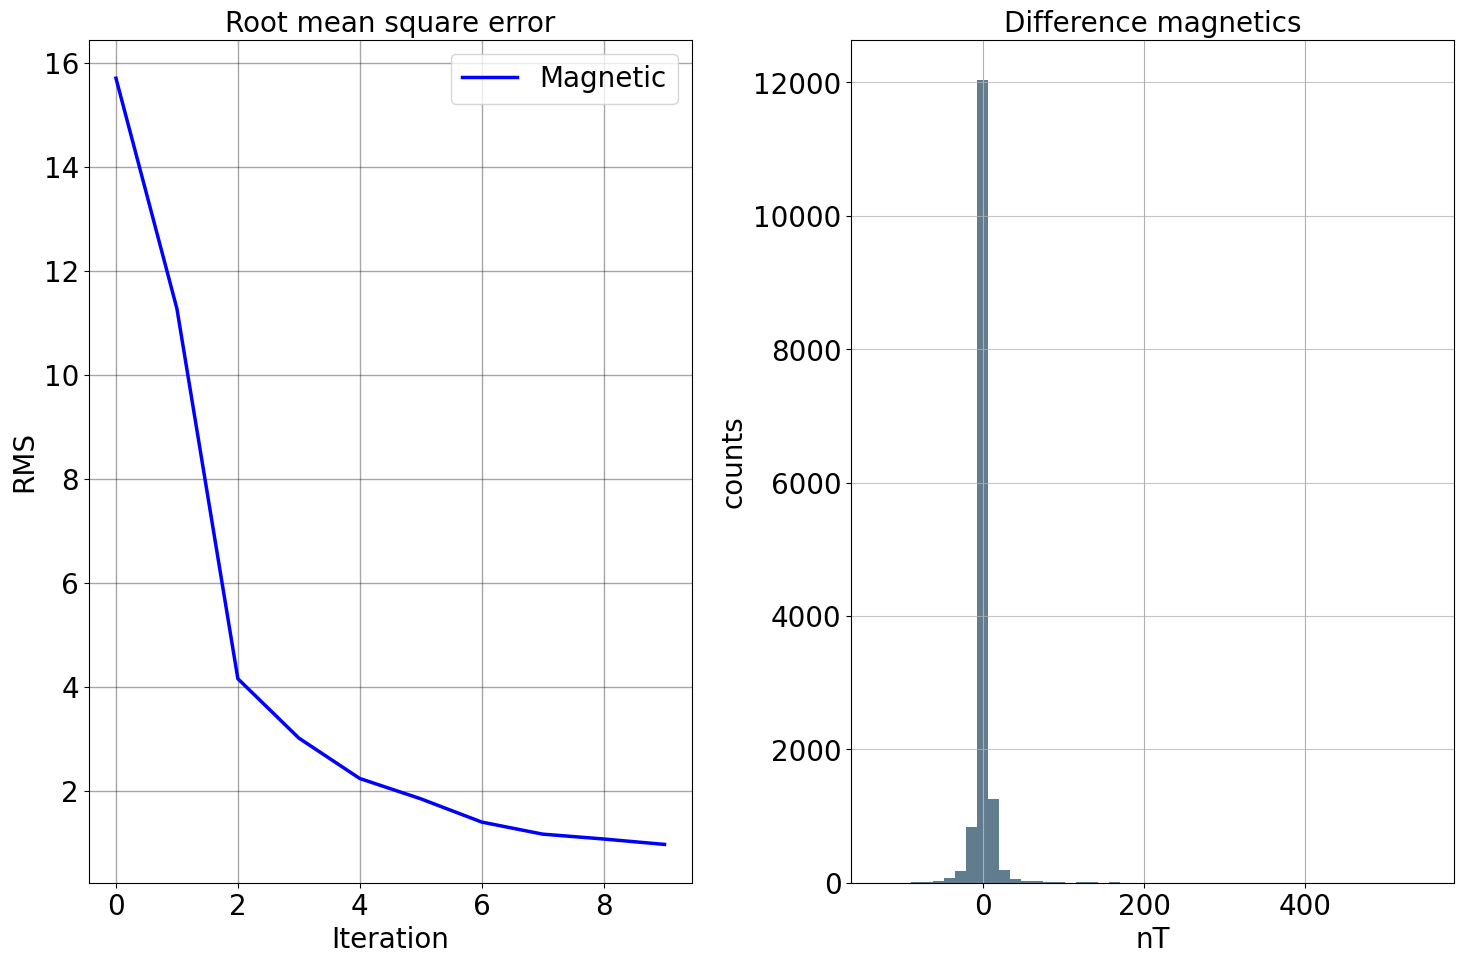

In [5]:
figure1, axs = plt.subplots(1, 2, figsize=(15,10),facecolor='white')

axs[0].plot(rms[:,1] , '-b' , linewidth=2.5 , label='Magnetic')
axs[0].legend(loc='upper right' , prop={'size': 20})
axs[0].set_title("Root mean square error" , fontsize=20)
axs[0].set_xlabel('RMS', fontsize=20)
axs[0].grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
axs[0].set_xlabel('Iteration' , fontsize=20)
axs[0].set_ylabel('RMS' , fontsize=20)
axs[0].tick_params(axis="x", labelsize=20) 
axs[0].tick_params(axis="y", labelsize=20) 


diff_mag_pd.diff_mag.plot.hist(grid=True, bins=50 , ax=axs[1] ,  color='#607c8e')
axs[1].set_title('Difference magnetics' , fontsize=20)
axs[1].set_xlabel('nT', fontsize=20)
axs[1].set_ylabel('counts', fontsize=20)
axs[1].grid(axis='y', alpha=0.75)
axs[1].tick_params(axis="x", labelsize=20) 
axs[1].tick_params(axis="y", labelsize=20) 

plt.savefig(inv_run+'Output/Figure/Mag_only_nversion_stats.png',facecolor=figure1.get_facecolor(), transparent=True)


figure1.tight_layout(pad=2)

print("max mag error :", '{0:.1f}'.format(np.max(diff_mag)) , "nT")
print("min mag error :", '{0:.1f}'.format(np.min(diff_mag)) , "nT"),
print("mean mag error :", '{0:.1f}'.format(np.mean(diff_mag)) , "nT")
print("std mag error :", '{0:.1f}'.format(np.std(diff_mag)) , "nT \n")



#### plot inversion maps

In [6]:
xq, yq = np.meshgrid(X_sus, Y_sus)
Depth_inversion_km = np.round((Depth_sus / 1000), 1)
Depth_sus

masked_array(data=[-3600., -3490., -3369., -3236., -3090., -2929., -2752.,
                   -2557., -2343., -2107., -1848., -1563., -1249.,  -904.,
                    -524.,  -106.,   353.,   858.,  1414.,  2026.,  2699.,
                    3439.,  4253.,  5148.,  6133.,  7216.,  8408.,  9719.,
                   11161., 12747., 14492., 16411., 18522., 20845., 23400.,
                   26210., 29301., 32701.],
             mask=False,
       fill_value=1e+20)

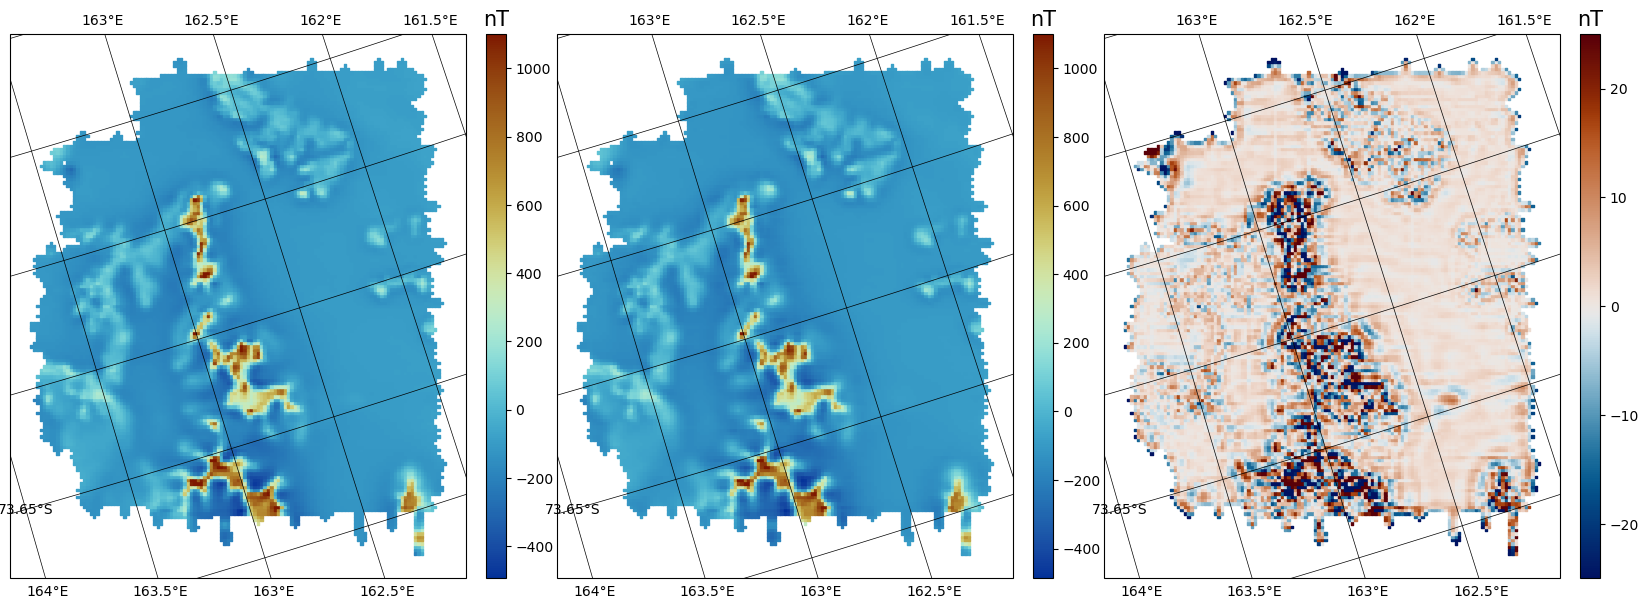

In [7]:
m=15 #fontsize

figure1 = plt.figure(figsize=(20,10),facecolor='white')

# observed mag map
ax1 = plt.subplot(1, 3, 1 , projection=ccrs.SouthPolarStereo())
im1 = plt.scatter(X_input_mag , Y_input_mag , c=val_input_mag , marker='s', s=3 , cmap =cmap , vmax = 1100 , 
                  transform=ccrs.SouthPolarStereo())
ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb1 = plt.colorbar(im1, cax=cax)
cb1.ax.set_title(unit_mag,fontsize=m)

# inverted mag map
ax2 = plt.subplot(1, 3, 2 , projection=ccrs.SouthPolarStereo())
im2 = plt.scatter(X_syn_mag , Y_syn_mag , c=val_syn_mag , marker='s', s=3 , cmap =cmap , vmax = 1100 ,
                  transform=ccrs.SouthPolarStereo())
ax2.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb2 = plt.colorbar(im2, cax=cax)
cb2.ax.set_title(unit_mag,fontsize=m)

# difference map
ax3 = plt.subplot(1, 3, 3 , projection=ccrs.SouthPolarStereo())
im3 = plt.scatter(X_input_mag , Y_input_mag , c=diff_mag , marker='s', s=3 , cmap=cmap_diff  , vmin = -25 , vmax = 25 ,
                  transform=ccrs.SouthPolarStereo())
ax3.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cax = figure1.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.01,axes.get_position().height])
cb3 = plt.colorbar(im3, cax=cax)
cb3.ax.set_title(unit_mag,fontsize=m)

plt.savefig(inv_run+'Output/Figure/mag_only_maps_with_profil_location.png',facecolor=figure1.get_facecolor(), transparent=True)


#### plot inversion depth slices

In [8]:
x_study_area = [507404.438756447,
                569404.438756447,
                569404.438756447,
                507404.438756447,
                507404.438756447]

y_study_area = [-1773582.79591434,
                -1773582.79591434,
                -1699582.79591434,
                -1699582.79591434,
                -1773582.79591434]

In [9]:
export_sus_dens_slide = inv_run + "Output/Figure/Fig1_inverted_sus_depth_slices/"
if not os.path.exists(export_sus_dens_slide):
    os.makedirs(export_sus_dens_slide)

for c in tqdm(range(len(Depth_inversion_km))):

    figure1 = plt.figure(figsize=(10, 8), facecolor="white")
    inv_sus_depth_slice = inv_sus[c, :, :]
    ax1 = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
    plt.title("Susceptibility at {:.1f} km depth".format(Depth_inversion_km[c]))
    im1 = plt.pcolormesh(
        xq, yq, inv_sus_depth_slice, cmap=cmap_rev, vmin=-0.05, vmax=0.05
    )
    ax1.gridlines(
        linewidth=0.5,
        draw_labels=True,
        color="k",
        alpha=1,
        linestyle="-",
        rotate_labels=0,
    )
    axes = plt.gca()
    cb = plt.colorbar(im1, shrink=1)
    cb.ax.set_title(unit_sus, fontsize=10)
    plt.plot(x_study_area, y_study_area, "r", linewidth=2, label="study area")
    ax1.legend(loc="lower right")
    export_name = export_sus_dens_slide + "horizontal_slice_{}.png".format(c + 100)
    plt.savefig(
        export_name, dpi=300, facecolor=figure1.get_facecolor(), transparent=True
    )
    plt.close()

# filepaths for in and out put
fp_in = inv_run + "Output/Figure/Fig1_inverted_sus_depth_slices/horizontal_slice_*.png"
fp_out = (
    inv_run
    + "Output/Figure/Fig1_inverted_sus_depth_slices/depth_slices_inversion_model.gif"
)

# create depth slice gif animation
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(
    fp=fp_out, format="GIF", append_images=imgs, save_all=True, duration=600, loop=0
)

  0%|          | 0/38 [00:00<?, ?it/s]

#### grid boundary surfaceses

In [10]:
topointer = griddata(
    (Boundaries_mensa_range.x_ps, Boundaries_mensa_range.y_ps),
    Boundaries_mensa_range.bedrock,
    (xq, yq),
    method="linear",
)

Mohointer = griddata(
    (Boundaries_mensa_range.x_ps, Boundaries_mensa_range.y_ps),
    Boundaries_mensa_range.Moho_Pappa,
    (xq, yq),
    method="linear",
)

CPDinter = griddata(
    (Boundaries_mensa_range.x_ps, Boundaries_mensa_range.y_ps),
    Boundaries_mensa_range.CPD_above_Moho,
    (xq, yq),
    method="linear",
)

x_profil, z_profil = np.meshgrid(X_sus, Depth_sus)

In [11]:
# create output folder
export_profiles_gif_vertical_ordered = (
    inv_run + "Output/Figure/Fig2_inverted_sus_cross_section/"
)

# Create path if it does not exists
if not os.path.exists(export_profiles_gif_vertical_ordered):
    os.makedirs(export_profiles_gif_vertical_ordered)

# define fontsize
fontsize_index = 10

# find data for current loop run
for j in tqdm(range(len(inv_sus[0, :, 0]))):

    sus_profil_ix = inv_sus[:, j, :]
    line_x = (min(x_profil[0, :]), max(x_profil[0, :]))
    line_y = (yq[j, 0], yq[j, 0])

    ## plot profile location
    figure1 = plt.figure(figsize=(15, 10), facecolor="white")
    spec = figure1.add_gridspec(2, 2, hspace=0.2, wspace=1)
    ax0 = figure1.add_subplot(spec[0, :])
    im1 = plt.scatter(
        X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=0.3, cmap=cmap_rev, vmax=1100
    )
    axes = plt.gca()
    cb1 = plt.colorbar(im1, shrink=1, orientation="vertical", pad=0.35)
    cb1.ax.set_title("nT", fontsize=fontsize_index)
    ax0.plot(line_x, line_y, color="k", linewidth=1)
    plt.gca().set_aspect(1)
    ax0.set_xlim(np.min(X_sus), np.max(X_sus))
    ax0.set_ylim(np.min(Y_sus), np.max(Y_sus))

    # plot sus profil
    ax2 = figure1.add_subplot(spec[1, :])
    im2 = plt.pcolormesh(
        x_profil, z_profil, sus_profil_ix, cmap=cmap_rev, vmin=-0.06, vmax=0.06
    )
    plt.xlabel("[m]", fontsize=fontsize_index)
    plt.ylabel("Depth [m]", fontsize=fontsize_index)
    ax2.set_ylim([-4000, 5000])
    ax2.set_xlim([505000, 572000])
    ax = plt.gca()
    ax.invert_yaxis()
    cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.35)
    cb.ax.set_title(unit_sus, fontsize=fontsize_index)
    plt.plot(x_profil[0, :], topointer[j, :] * -1, c="red", label="Bedrock")
    #     plt.plot(x_profil[0,:],CPDinter[j,:]*1000 , c='c' , label='CPD')
    #     plt.plot(x_profil[0,:],Mohointer[j,:]*1000 , c='blue', label='Moho')
    ax2.legend(loc="lower right", prop={"size": 10})

    # export figure
    export_name1 = (
        export_profiles_gif_vertical_ordered + "vertical_slice_{}.png".format(j + 100)
    )
    plt.savefig(
        export_name1, dpi=300, facecolor=figure1.get_facecolor(), transparent=True
    )

    plt.close()

# # filepaths for in and out put
fp_in = inv_run + "Output/Figure/Fig2_inverted_sus_cross_section/vertical_slice*.png"
fp_out = (
    inv_run
    + "Output/Figure/Fig2_inverted_sus_cross_section/vertical_slices_inversion_model.gif"
)

# create depth slice gif animation
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(
    fp=fp_out, format="GIF", append_images=imgs, save_all=True, duration=600, loop=0
)

  0%|          | 0/324 [00:00<?, ?it/s]

#### load GeoMap data

In [12]:
filename = "DATA/GeoMap_Ferrar_df.geojson"
file = open(filename)
Ferrar = gpd.read_file(file)

filename = "DATA/GeoMap_GHI_df.geojson"
file = open(filename)
GHI_wsb = gpd.read_file(file)

filename = "DATA/GeoMap_KPB_df.geojson"
file = open(filename)
Kirkpatrick_Basalt_geomap = gpd.read_file(file)

filename = "DATA/GeoMap_Coastline_df.geojson"
file = open(filename)
Coastline = gpd.read_file(file)

filename = "DATA/GeoMap_faults_df.geojson"
file = open(filename)
faults = gpd.read_file(file)



#### load petrological measurements  

In [13]:
NAPA_measurments_df = pd.read_csv(
    "../../../petrological_data/combinded_NAPA_BGR_measurements/Prep_meassurements_for_publication/merged_dataset_NAPA_BGR_ML_JL_MG_cleaned.csv"
)

NAPA_measurments_df["susceptibility_1"] = NAPA_measurments_df["susceptibility_1"] * 1e-3
NAPA_measurments_df["susceptibility_2"] = NAPA_measurments_df["susceptibility_2"] * 1e-3
NAPA_measurments_df["susceptibility_3"] = NAPA_measurments_df["susceptibility_3"] * 1e-3
NAPA_measurments_df["susceptibility_4"] = NAPA_measurments_df["susceptibility_4"] * 1e-3
NAPA_measurments_df["susceptibility_5"] = NAPA_measurments_df["susceptibility_5"] * 1e-3
NAPA_measurments_df["susceptibility_6"] = NAPA_measurments_df["susceptibility_6"] * 1e-3
NAPA_measurments_df["susceptibility_7"] = NAPA_measurments_df["susceptibility_7"] * 1e-3
NAPA_measurments_df["susceptibility_8"] = NAPA_measurments_df["susceptibility_8"] * 1e-3
NAPA_measurments_df["susceptibility_average"] = (
    NAPA_measurments_df["susceptibility_average"] * 1e-3
)
NAPA_measurments_df["susceptibility_std"] = (
    NAPA_measurments_df["susceptibility_std"] * 1e-3
)
NAPA_measurments_df["density"] = NAPA_measurments_df["density"] * 1000

#### project KPB location from lon lat to polar Stereographic

In [14]:
NAPA_Kirkpatrick_Basalts_formation_df = NAPA_measurments_df[(NAPA_measurments_df['stratigraphy'] == 'Kirkpatrick Basalts') |
                                                            (NAPA_measurments_df['stratigraphy'] == 'Kirkpatrick Laven')]


NAPA_Kirkpatrick_Basalts_basalt_only_df = NAPA_Kirkpatrick_Basalts_formation_df[
                                        (NAPA_Kirkpatrick_Basalts_formation_df['rocktyp'] == 'KPB')]

## convert lon lat to decimal
longitude_pd = NAPA_Kirkpatrick_Basalts_basalt_only_df['longitude']
latitude_pd = NAPA_Kirkpatrick_Basalts_basalt_only_df['latitude']

longitude = longitude_pd.to_numpy()
latitude = latitude_pd.to_numpy()

lon_decimal = np.zeros((len(NAPA_Kirkpatrick_Basalts_basalt_only_df),1))
lat_decimal = np.zeros((len(NAPA_Kirkpatrick_Basalts_basalt_only_df),1))

for i in range(len(NAPA_Kirkpatrick_Basalts_basalt_only_df)):
    if pd.isna(latitude[i]) != True  :
        lon_deg = float(longitude[i][0:3])
        lon_min = float(longitude[i][5:7])
        lon_ix = lon_deg + ((lon_min)/60)
        lon_decimal[i] = lon_ix

        lat_deg = float(latitude[i][0:2])
        lat_min = float(latitude[i][4:6])
        lat_ix = (lat_deg + ((lat_min)/60))*-1  # south needs minus for maps plotting
        lat_decimal[i] = lat_ix    
NAPA_Kirkpatrick_Basalts_basalt_only_df = NAPA_Kirkpatrick_Basalts_basalt_only_df.assign(longitude_deg=lon_decimal)        
NAPA_Kirkpatrick_Basalts_basalt_only_df = NAPA_Kirkpatrick_Basalts_basalt_only_df.assign(latitude_deg=lat_decimal)   

## create geopanda dataframe
NAPA_Kirkpatrick_Basalts_basalt_only_gpdf = gpd.GeoDataFrame(NAPA_Kirkpatrick_Basalts_basalt_only_df, geometry=gpd.points_from_xy(
                        NAPA_Kirkpatrick_Basalts_basalt_only_df.longitude_deg, NAPA_Kirkpatrick_Basalts_basalt_only_df.latitude_deg), crs="EPSG:4326")

## reproject geopanda dataframe to sterographic coordinates
NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf = NAPA_Kirkpatrick_Basalts_basalt_only_gpdf.to_crs(3031)

NAPA_Kirkpatrick_Basalts_density_mean = np.mean(NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf['density'])
NAPA_Kirkpatrick_Basalts_density_std = np.std(NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf['density'])
NAPA_Kirkpatrick_Basalts_sus_mean = np.mean(NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf['susceptibility_average'])
NAPA_Kirkpatrick_Basalts_sus_std = np.std(NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf['susceptibility_average'])


#### project Ferrar location from lon lat to polar Stereographic

In [15]:
NAPA_Ferrar_df = NAPA_measurments_df[(NAPA_measurments_df['stratigraphy'] == 'Ferrar Dolerites') |
                                     (NAPA_measurments_df['stratigraphy'] == 'Ferrar Dolerite')]


NAPA_Ferrar_dolerite_only_df = NAPA_Ferrar_df[(NAPA_Ferrar_df['rocktyp'] == 'Dolerit') |
                                              (NAPA_Ferrar_df['rocktyp'] == 'Ferrar Dolerite') |
                                              (NAPA_Ferrar_df['rocktyp'] == 'FD')]

## convert lon lat to decimal
longitude_pd = NAPA_Ferrar_dolerite_only_df['longitude']
latitude_pd = NAPA_Ferrar_dolerite_only_df['latitude']

longitude = longitude_pd.to_numpy()
latitude = latitude_pd.to_numpy()

lon_decimal = np.zeros((len(NAPA_Ferrar_dolerite_only_df),1))
lat_decimal = np.zeros((len(NAPA_Ferrar_dolerite_only_df),1))

for i in range(len(NAPA_Ferrar_dolerite_only_df)):
    if pd.isna(latitude[i]) != True  :
        lon_deg = float(longitude[i][0:3])
        lon_min = float(longitude[i][5:7])
        lon_ix = lon_deg + ((lon_min)/60)
        lon_decimal[i] = lon_ix

        lat_deg = float(latitude[i][0:2])
        lat_min = float(latitude[i][4:6])
        lat_ix = (lat_deg + ((lat_min)/60))*-1  # south needs minus for maps plotting
        lat_decimal[i] = lat_ix    
NAPA_Ferrar_dolerite_only_df = NAPA_Ferrar_dolerite_only_df.assign(longitude_deg=lon_decimal)        
NAPA_Ferrar_dolerite_only_df = NAPA_Ferrar_dolerite_only_df.assign(latitude_deg=lat_decimal)   

## create geopanda dataframe
NAPA_Ferrar_dolerite_only_gpdf = gpd.GeoDataFrame(NAPA_Ferrar_dolerite_only_df, geometry=gpd.points_from_xy(
                        NAPA_Ferrar_dolerite_only_df.longitude_deg, NAPA_Ferrar_dolerite_only_df.latitude_deg), crs="EPSG:4326")

## reproject geopanda dataframe to sterographic coordinates
NAPA_Ferrar_dolerite_only_ps_gpdf = NAPA_Ferrar_dolerite_only_gpdf.to_crs(3031)

NAPA_Ferrar_density_mean = np.mean(NAPA_Ferrar_dolerite_only_ps_gpdf['density'])
NAPA_Ferrar_density_std = np.std(NAPA_Ferrar_dolerite_only_ps_gpdf['density'])
NAPA_Ferrar_sus_mean = np.mean(NAPA_Ferrar_dolerite_only_ps_gpdf['susceptibility_average'])
NAPA_Ferrar_sus_std = np.std(NAPA_Ferrar_dolerite_only_ps_gpdf['susceptibility_average'])


#### project GHI location from lon lat to polar Stereographic

In [16]:
NAPA_GHI_df = NAPA_measurments_df[
    (NAPA_measurments_df["stratigraphy"] == "Granite Harbour Intrusives")
]

NAPA_GHI__granite_only_df = NAPA_GHI_df[
    (NAPA_GHI_df["rocktyp"] == "Granite")
    | (NAPA_GHI_df["rocktyp"] == "Granite, fine-grained")
    | (NAPA_GHI_df["rocktyp"] == "Granite, small- to fine-grained")
    | (NAPA_GHI_df["rocktyp"] == "Granite, small-grained")
    | (NAPA_GHI_df["rocktyp"] == "Granite, medium to coarse-grained")
    | (NAPA_GHI_df["rocktyp"] == "Granite, medium-grained")
    | (NAPA_GHI_df["rocktyp"] == "Large grain-Granite")
    | (NAPA_GHI_df["rocktyp"] == "Granite/Orthogneiss")
    | (NAPA_GHI_df["rocktyp"] == "Granite-Gneiss, medium-grain")
    | (NAPA_GHI_df["rocktyp"] == "Granite-Mylonit")
    | (NAPA_GHI_df["rocktyp"] == "sc-Mylonite im Granite")
    | (NAPA_GHI_df["rocktyp"] == "Granite, coarse-grained")
]
## convert lon lat to decimal
longitude_pd = NAPA_GHI__granite_only_df["longitude"]
latitude_pd = NAPA_GHI__granite_only_df["latitude"]

longitude = longitude_pd.to_numpy()
latitude = latitude_pd.to_numpy()

lon_decimal = np.zeros((len(NAPA_GHI__granite_only_df), 1))
lat_decimal = np.zeros((len(NAPA_GHI__granite_only_df), 1))

for i in range(len(NAPA_GHI__granite_only_df)):
    if pd.isna(latitude[i]) != True:
        lon_deg = float(longitude[i][0:3])
        lon_min = float(longitude[i][5:7])
        lon_ix = lon_deg + ((lon_min) / 60)
        lon_decimal[i] = lon_ix

        lat_deg = float(latitude[i][0:2])
        lat_min = float(latitude[i][4:6])
        lat_ix = (
            lat_deg + ((lat_min) / 60)
        ) * -1  # south needs minus for maps plotting
        lat_decimal[i] = lat_ix
NAPA_GHI__granite_only_df = NAPA_GHI__granite_only_df.assign(longitude_deg=lon_decimal)
NAPA_GHI__granite_only_df = NAPA_GHI__granite_only_df.assign(latitude_deg=lat_decimal)

## create geopanda dataframe
NAPA_GHI__granite_only_gpdf = gpd.GeoDataFrame(
    NAPA_GHI__granite_only_df,
    geometry=gpd.points_from_xy(
        NAPA_GHI__granite_only_df.longitude_deg, NAPA_GHI__granite_only_df.latitude_deg
    ),
    crs="EPSG:4326",
)

## reproject geopanda dataframe to sterographic coordinates
NAPA_GHI__granite_only_ps_gpdf = NAPA_GHI__granite_only_gpdf.to_crs(3031)

NAPA_GHI_density_mean = np.mean(NAPA_GHI__granite_only_ps_gpdf["density"])
NAPA_GHI_density_std = np.std(NAPA_GHI__granite_only_ps_gpdf["density"])
NAPA_GHI_sus_mean = np.mean(NAPA_GHI__granite_only_ps_gpdf["susceptibility_average"])
NAPA_GHI_sus_std = np.std(NAPA_GHI__granite_only_ps_gpdf["susceptibility_average"])

#### plot petrological measurements and sample location 

FD density mean 2876.9615384615386
KPB density mean 2747.2549019607845
GHI density mean 2598.8205128205127


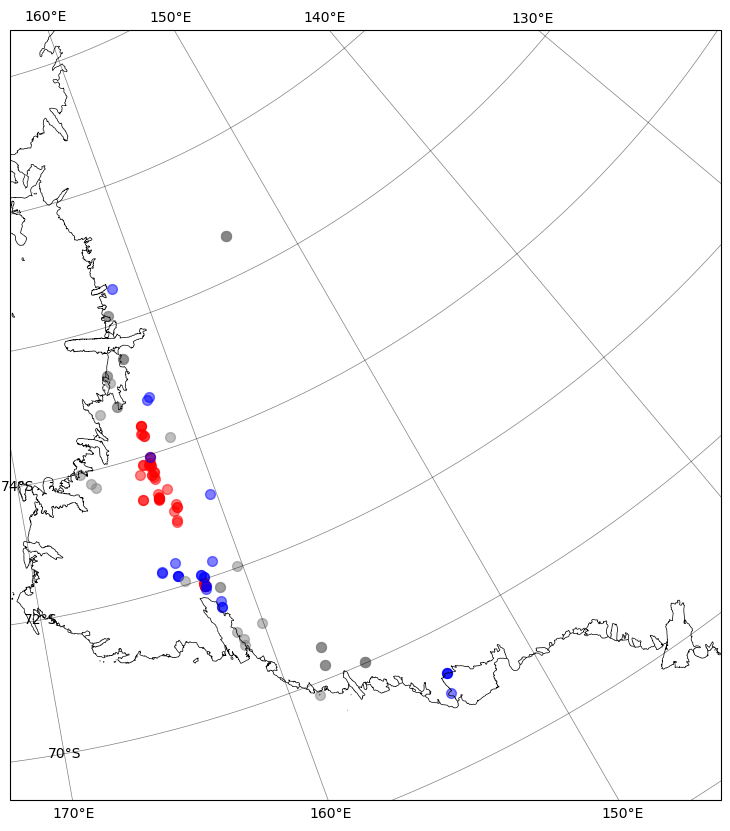

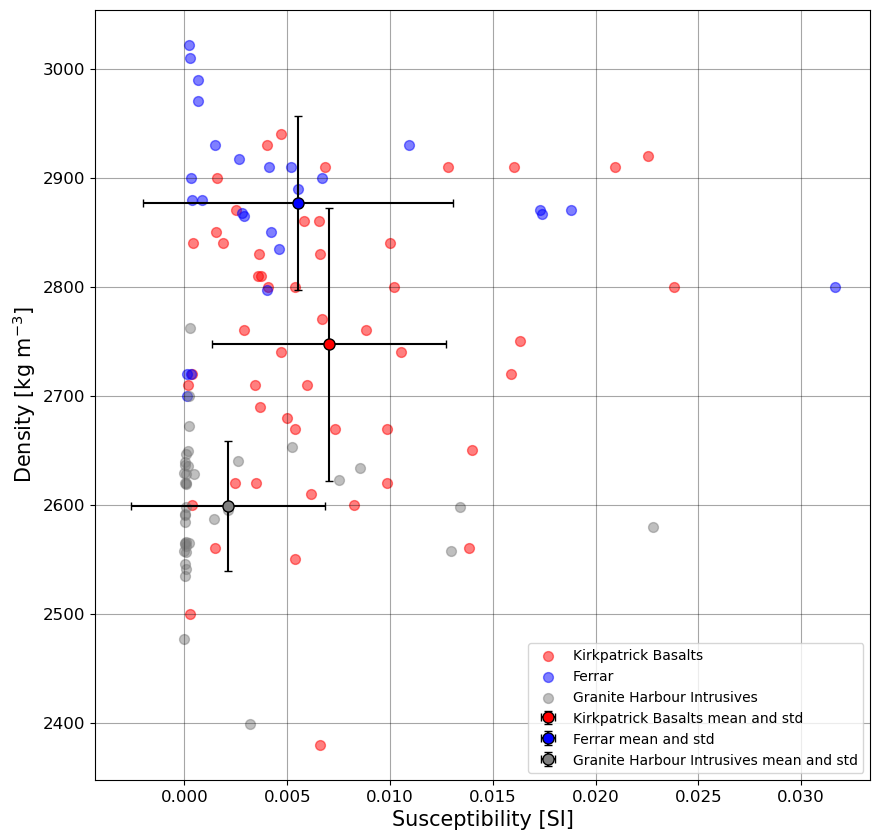

In [17]:
# ploting the location of Basalt samples
figure1 = plt.figure(figsize=(16,10),facecolor='white')
ax1 = plt.subplot(1, 1, 1 , projection=ccrs.SouthPolarStereo())
NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf.plot(ax=ax1 , marker='o', color='red', markersize=50 , alpha=0.5)
NAPA_Ferrar_dolerite_only_ps_gpdf.plot(ax=ax1 , marker='o', color='blue', markersize=50 , alpha=0.5)
NAPA_GHI__granite_only_ps_gpdf.plot(ax=ax1 , marker='o', color='gray', markersize=50 , alpha=0.5)

Coastline.plot(ax=ax1 , color = 'k' , linewidth = 0.5)
ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=0.5, linestyle='-' , rotate_labels=0)
ax1.set_xlim([0.3e6, 1.5e6])
ax1.set_ylim([-2.3e6, -1e6])

figure2 = plt.figure(figsize=(10,10),facecolor='white')
ax1 = plt.subplot(1, 1, 1 )
NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                                  s=50 ,c='red', alpha=0.5 , label='Kirkpatrick Basalts')

plt.errorbar(NAPA_Kirkpatrick_Basalts_sus_mean  , NAPA_Kirkpatrick_Basalts_density_mean , xerr=NAPA_Kirkpatrick_Basalts_sus_std, 
             yerr=NAPA_Kirkpatrick_Basalts_density_std , fmt='ko' , markersize=8 , markerfacecolor= "red" , 
             markeredgecolor="k" , capsize=3 , label='Kirkpatrick Basalts mean and std')

NAPA_Ferrar_dolerite_only_ps_gpdf.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , s=50 ,c='blue', 
                              alpha=0.5 , label='Ferrar')

plt.errorbar(NAPA_Ferrar_sus_mean  , NAPA_Ferrar_density_mean , xerr=NAPA_Ferrar_sus_std , yerr=NAPA_Ferrar_density_std , 
             fmt='ko' , markersize=8 , markerfacecolor= "blue" , markeredgecolor="k" , capsize=3 , 
             label='Ferrar mean and std')

NAPA_GHI__granite_only_ps_gpdf.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , s=50 ,c='gray', 
                              alpha=0.5 , label='Granite Harbour Intrusives')

plt.errorbar(NAPA_GHI_sus_mean  , NAPA_GHI_density_mean , xerr=NAPA_GHI_sus_std , 
             yerr=NAPA_GHI_density_std , fmt='ko' , markersize=8 , markerfacecolor= "gray" , markeredgecolor="k" ,
             capsize=3 , label='Granite Harbour Intrusives mean and std')

ax1.grid(visible=True, which='major' , color='k', linestyle='-' , alpha=0.35)
ax1.set_xlabel('Susceptibility [SI]' , fontsize=15)
ax1.set_ylabel('Density [kg m$^{-3}$]' , fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right')
plt.savefig(export_fig_path + "sus_dens_crossplot_KPB_Ferra_GHI",dpi=300,facecolor=figure1.get_facecolor(), transparent=True)

print('FD density mean', NAPA_Ferrar_density_mean)
print('KPB density mean', NAPA_Kirkpatrick_Basalts_density_mean)
print('GHI density mean', NAPA_GHI_density_mean)


#### Clip inversion model to values below bedrock topography

In [18]:
boundary_Topo = (
    Boundaries_mensa_range.bedrock * -1
)  # model geometry is defined as postive = down
topointer = griddata(
    (Boundaries_mensa_range.x_ps, Boundaries_mensa_range.y_ps),
    boundary_Topo,
    (xq, yq),
    method="linear",
)

In [19]:
depth_slices_index = 10  # depth index
inv_sus_depth_slice = inv_sus[depth_slices_index, :, :]

inv_sus_data_ix = np.vstack(
    (xq.flatten(), yq.flatten(), inv_sus_depth_slice.flatten())
).T
topo_data_ix = np.vstack((xq.flatten(), yq.flatten(), topointer.flatten())).T

inv_sus_cleaned = []

for i in range(len(inv_sus_data_ix[:, 0])):
    if Depth_inversion_km[depth_slices_index] * 1000 > topo_data_ix[i, 2]:
        inv_sus_cleaned.append(inv_sus_data_ix[i, :])

Sus_cleaned_data_for_histogram = np.array(inv_sus_cleaned)

In [20]:
inv_sus_d = {
    "Xps": Sus_cleaned_data_for_histogram[:, 0],
    "Yps": Sus_cleaned_data_for_histogram[:, 1],
    "inv_sus": Sus_cleaned_data_for_histogram[:, 2],
}
inv_sus_df = pd.DataFrame(data=inv_sus_d)
inv_sus_gdf = gpd.GeoDataFrame(
    inv_sus_df,
    geometry=gpd.points_from_xy(inv_sus_df.Xps, inv_sus_df.Yps),
    crs="EPSG:3031",
)
inv_sus_gdf

,Xps,Yps,inv_sus,geometry
0,548154.438756,-1.785707e+06,3.361061e-13,POINT (548154.439 -1785706.796)
1,548404.438756,-1.785707e+06,1.844646e-03,POINT (548404.439 -1785706.796)
2,548654.438756,-1.785707e+06,2.082468e-03,POINT (548654.439 -1785706.796)
3,548904.438756,-1.785707e+06,2.081400e-03,POINT (548904.439 -1785706.796)
4,577441.438756,-1.785707e+06,8.600204e-13,POINT (577441.439 -1785706.796)
...,...,...,...,...
54694,564654.438756,-1.684784e+06,2.298582e-03,POINT (564654.439 -1684783.796)
54695,564904.438756,-1.684784e+06,2.275761e-03,POINT (564904.439 -1684783.796)
54696,565154.438756,-1.684784e+06,2.252321e-03,POINT (565154.439 -1684783.796)
54697,565404.438756,-1.684784e+06,2.227504e-03,POINT (565404.439 -1684783.796)


#### plot geology, faults, rock location superimposed on inverted sus model

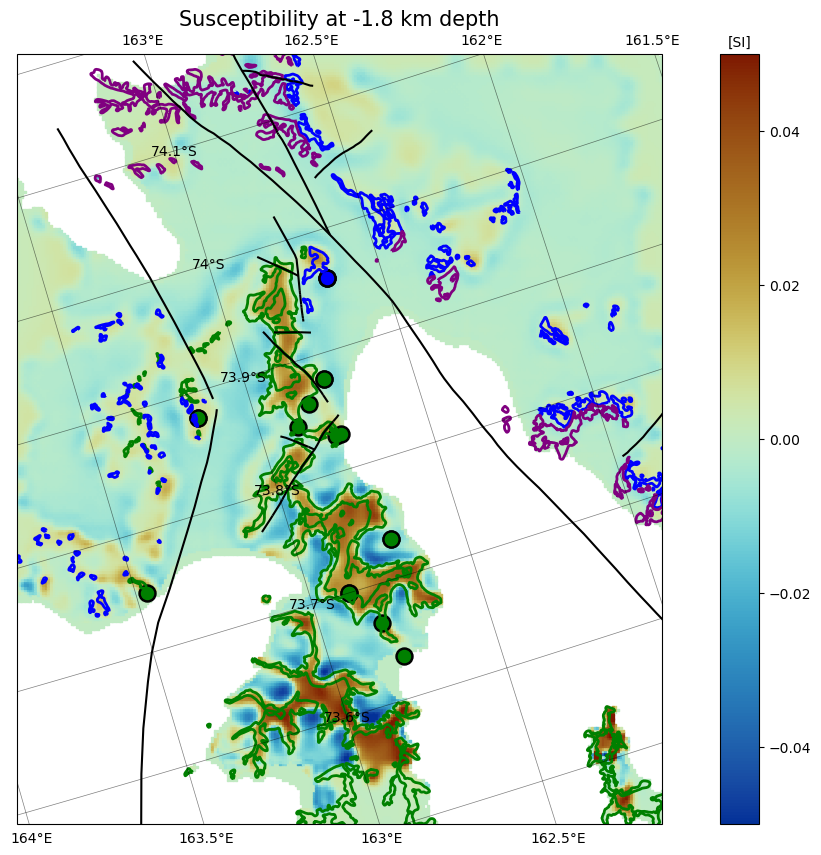

In [21]:
figure1 = plt.figure(figsize=(15, 10), facecolor="white")

ax1 = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
im1 = plt.scatter(
    Sus_cleaned_data_for_histogram[:, 0],
    Sus_cleaned_data_for_histogram[:, 1],
    c=Sus_cleaned_data_for_histogram[:, 2],
    marker="s",
    s=2,
    cmap=cmap,
    vmin=-0.05,
    vmax=0.05,
    transform=ccrs.SouthPolarStereo(),
)

Kirkpatrick_Basalt_geomap.boundary.plot(ax=ax1, color="green", linewidth=2)
ax1.plot([0, 0], "o", color="green", label="Kirkpatrick Basalt")

Ferrar.boundary.plot(ax=ax1, color="blue", linewidth=2)
ax1.plot([0, 0], "o", color="blue", label="Ferrar")

GHI_wsb.boundary.plot(ax=ax1, color="purple", linewidth=2)
ax1.plot([0, 0], "o", color="purple", label="Granite Harbour Intrusives")

faults.plot(ax=ax1, color="k", linewidth=1.5)

NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf.plot(
    ax=ax1, marker="o", color="k", markersize=150, alpha=1
)
NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf.plot(
    ax=ax1, marker="o", color="green", markersize=75, alpha=1
)

NAPA_Ferrar_dolerite_only_ps_gpdf.plot(
    ax=ax1, marker="o", color="k", markersize=150, alpha=1
)
NAPA_Ferrar_dolerite_only_ps_gpdf.plot(
    ax=ax1, marker="o", color="blue", markersize=75, alpha=1
)

plt.title(
    "Susceptibility at {:.1f} km depth".format(Depth_inversion_km[depth_slices_index]), fontsize=15
)

ax1.gridlines(
    linewidth=0.5,
    draw_labels=True,
    color="k",
    alpha=0.5,
    linestyle="-",
    rotate_labels=0,
)

axes = plt.gca()
cb = plt.colorbar(im1, shrink=1)
cb.ax.set_title("[SI]", fontsize=10)
ax1.set_xlim([507404.438756447, 569404.438756447])
ax1.set_ylim([-1773582.79591434, -1699582.79591434])
# ax1.legend(loc='upper right')
plt.savefig(
    export_fig_path + "sus_slices_with_geo_map_and_rock_location",
    dpi=300,
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

#### clip inversion against GeoMap

In [22]:
inv_sus_cliped_kirkpatrick_gpd = gpd.clip(inv_sus_gdf, Kirkpatrick_Basalt_geomap)
inv_sus_cliped_Ferrar_gpd = gpd.clip(inv_sus_gdf, Ferrar)
inv_sus_cliped_GHI_wsb_gpd = gpd.clip(inv_sus_gdf, GHI_wsb)

#### shift inversion sus values

In [23]:
shift_value = 0.004

inv_sus_cliped_kirkpatrick_shifted_gpd = (
    inv_sus_cliped_kirkpatrick_gpd["inv_sus"] + shift_value
)
inv_sus_cliped_Ferrar_shifted_gpd = inv_sus_cliped_Ferrar_gpd["inv_sus"] + shift_value
inv_sus_cliped_GHI_wsb_shifted_gpd = inv_sus_cliped_GHI_wsb_gpd["inv_sus"] + shift_value

inv_sus_all_shifted_gpd = inv_sus_gdf
inv_sus_all_shifted_gpd["inv_sus"] = inv_sus_all_shifted_gpd["inv_sus"] + shift_value

#### plot rock measurements and KDE

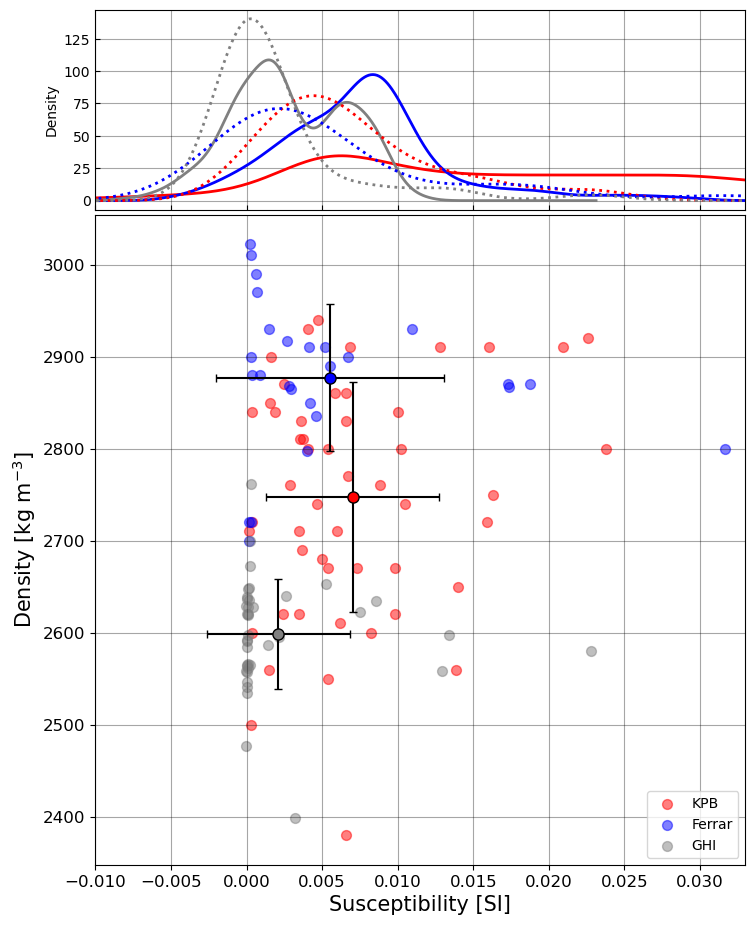

In [24]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]


figure2 = plt.figure(figsize=(10,10),facecolor='white')
ax1 = plt.axes(rect_scatter)
NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , 
                                                  s=50 ,c='red', alpha=0.5 , label='KPB' )

plt.errorbar(NAPA_Kirkpatrick_Basalts_sus_mean  , NAPA_Kirkpatrick_Basalts_density_mean , xerr=NAPA_Kirkpatrick_Basalts_sus_std, 
             yerr=NAPA_Kirkpatrick_Basalts_density_std , fmt='ko' , markersize=8 , markerfacecolor= "red" , 
             markeredgecolor="k" , capsize=3 )



NAPA_Ferrar_dolerite_only_ps_gpdf.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , s=50 ,c='blue', 
                              alpha=0.5 , label='Ferrar')

plt.errorbar(NAPA_Ferrar_sus_mean  , NAPA_Ferrar_density_mean , xerr=NAPA_Ferrar_sus_std , yerr=NAPA_Ferrar_density_std , 
             fmt='ko' , markersize=8 , markerfacecolor= "blue" , markeredgecolor="k" , capsize=3)


NAPA_GHI__granite_only_ps_gpdf.plot(kind="scatter",   ax=ax1 , x='susceptibility_average' ,  y='density' , marker='o' , s=50 ,c='gray', 
                              alpha=0.5 , label='GHI')

plt.errorbar(NAPA_GHI_sus_mean  , NAPA_GHI_density_mean , xerr=NAPA_GHI_sus_std , 
             yerr=NAPA_GHI_density_std , fmt='ko' , markersize=8 , markerfacecolor= "gray" , markeredgecolor="k" ,
             capsize=3)


ax1.grid(visible=True, which='major' , color='k', linestyle='-' , alpha=0.35)
ax1.set_xlabel('Susceptibility [SI]' , fontsize=15)
ax1.set_ylabel('Density [kg m$^{-3}$]' , fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1.set_xlim([-0.01, 0.033])
plt.legend(loc='lower right')

ax_histx = plt.axes(rect_histx, sharex=ax1)
ax_histx.tick_params(direction='in', labelbottom=False)

inv_sus_cliped_kirkpatrick_shifted_gpd.plot.kde(ax=ax_histx , color='red', linestyle="-", lw=2)

inv_sus_cliped_Ferrar_shifted_gpd.plot.kde(ax=ax_histx , color='blue', linestyle="-", lw=2)

inv_sus_cliped_GHI_wsb_shifted_gpd.plot.kde(ax=ax_histx , color='gray', linestyle="-", lw=2)


NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf['susceptibility_average'].plot.kde(ax=ax_histx , color='red', linestyle=":", lw=2)

NAPA_Ferrar_dolerite_only_ps_gpdf['susceptibility_average'].plot.kde(ax=ax_histx , color='blue', linestyle=":", lw=2)

NAPA_GHI__granite_only_ps_gpdf['susceptibility_average'].plot.kde(ax=ax_histx , color='gray', linestyle=":", lw=2)


ax_histx.grid(visible=True, which='major' , color='k', linestyle='-' , alpha=0.35)

plt.savefig(export_fig_path + "sus_dens_crossplot_KPB_Ferra_GHI",dpi=300,facecolor=figure1.get_facecolor(), transparent=True)


#### plot histograms and KDE of inverted and rock measurements

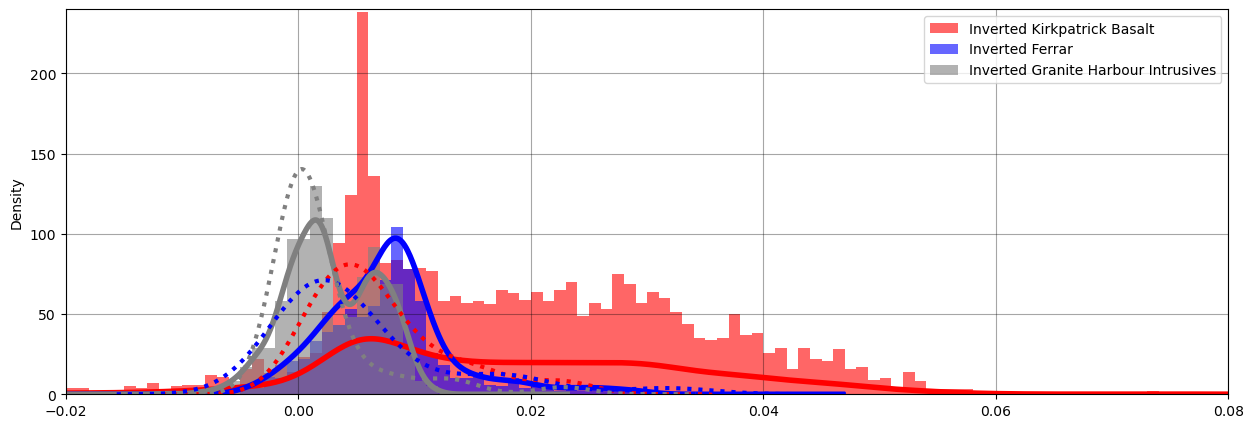

In [25]:
figure1 = plt.figure(figsize=(15,5),facecolor='white')
ax1 = plt.subplot(1, 1, 1)
inv_sus_cliped_kirkpatrick_shifted_gpd.hist(grid=True, bins=100, range=(-0.02,0.08) , ax=ax1 ,  color='red', alpha =.6,label='Inverted Kirkpatrick Basalt')
inv_sus_cliped_Ferrar_shifted_gpd.hist(grid=True, bins=100, range=(-0.02,0.08) , ax=ax1 ,  color='blue', alpha =.6,label='Inverted Ferrar')
inv_sus_cliped_GHI_wsb_shifted_gpd.hist(grid=True, bins=100, range=(-0.02,0.08) , ax=ax1 ,  color='gray', alpha =.6,label='Inverted Granite Harbour Intrusives')
ax1.legend(loc='upper right')

inv_sus_cliped_kirkpatrick_shifted_gpd.plot.kde(color='red',lw=4)
inv_sus_cliped_Ferrar_shifted_gpd.plot.kde(color='blue',lw=4)
inv_sus_cliped_GHI_wsb_shifted_gpd.plot.kde(color='gray',lw=4, grid=True )

NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf['susceptibility_average'].plot.kde(color='red', linestyle=":", lw=3)

NAPA_Ferrar_dolerite_only_ps_gpdf['susceptibility_average'].plot.kde(color='blue', linestyle=":", lw=3)

NAPA_GHI__granite_only_ps_gpdf['susceptibility_average'].plot.kde(color='gray', linestyle=":", lw=3)

ax1.grid(visible=True, which='major' , color='k', linestyle='-' , alpha=0.35)


ax1.set_xlim(-0.02, 0.08)
ax1.set_ylim(0, 240)
plt.savefig(export_fig_path + "inverted_ferrar_kpb_GHI",dpi=300,facecolor=figure1.get_facecolor(), transparent=True)


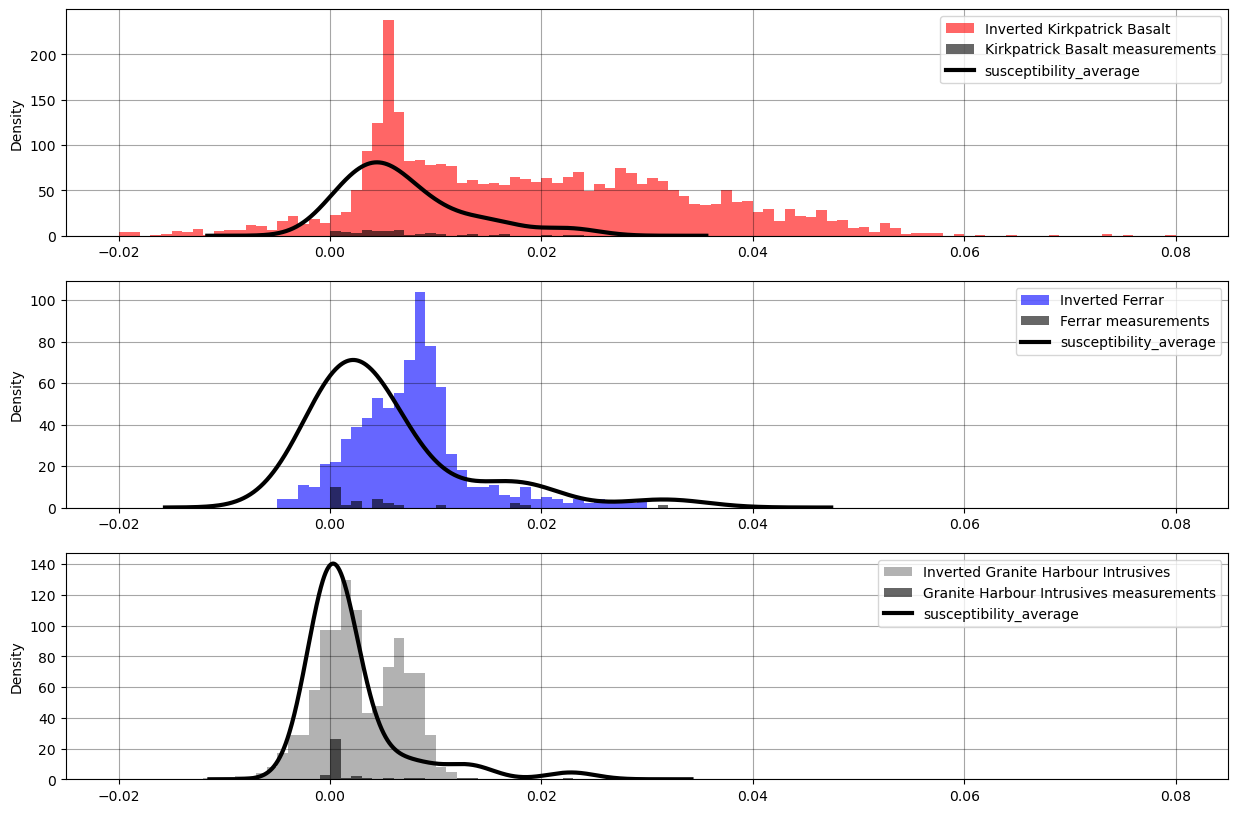

In [26]:
figure1 = plt.figure(figsize=(15,10),facecolor='white')

ax1 = plt.subplot(3, 1, 1)
inv_sus_cliped_kirkpatrick_shifted_gpd.hist(grid=True, bins=100, range=(-0.02,0.08) , ax=ax1 ,  color='red', alpha =.6,label='Inverted Kirkpatrick Basalt')
NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf['susceptibility_average'].hist(grid=True, bins=100, range=(-0.02,0.08) , ax=ax1 ,  color='k', alpha =.6,label='Kirkpatrick Basalt measurements')
NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf['susceptibility_average'].plot.kde(color='k', linestyle="-", lw=3)
ax1.legend(loc='upper right')
ax1.grid(visible=True, which='major' , color='k', linestyle='-' , alpha=0.35)


ax2 = plt.subplot(3, 1, 2)
inv_sus_cliped_Ferrar_shifted_gpd.hist(grid=True, bins=100, range=(-0.02,0.08) , ax=ax2 ,  color='blue', alpha =.6,label='Inverted Ferrar')
NAPA_Ferrar_dolerite_only_ps_gpdf['susceptibility_average'].hist(grid=True, bins=100, range=(-0.02,0.08) , ax=ax2 ,  color='k', alpha =.6,label='Ferrar measurements')
NAPA_Ferrar_dolerite_only_ps_gpdf['susceptibility_average'].plot.kde(color='k', linestyle="-", lw=3)
ax2.legend(loc='upper right')
ax2.grid(visible=True, which='major' , color='k', linestyle='-' , alpha=0.35)


ax3 = plt.subplot(3, 1, 3)
inv_sus_cliped_GHI_wsb_shifted_gpd.hist(grid=True, bins=100, range=(-0.02,0.08) , ax=ax3 ,  color='gray', alpha =.6,label='Inverted Granite Harbour Intrusives')
NAPA_GHI__granite_only_ps_gpdf['susceptibility_average'].hist(grid=True, bins=100, range=(-0.02,0.08) , ax=ax3 ,  color='k', alpha =.6,label='Granite Harbour Intrusives measurements')
NAPA_GHI__granite_only_ps_gpdf['susceptibility_average'].plot.kde(color='k', linestyle="-", lw=3)
ax3.legend(loc='upper right')
ax3.grid(visible=True, which='major' , color='k', linestyle='-' , alpha=0.35)
plt.savefig(export_fig_path + "comparison_inverted_measurement_sus",dpi=300,facecolor=figure1.get_facecolor(), transparent=True)


#### plotting cliped inverted sus ranges of KBP and Ferrar

In [27]:
inv_sus_Ferrar_cliped = inv_sus_all_shifted_gpd[(inv_sus_all_shifted_gpd["inv_sus"] > 0.004) & (inv_sus_all_shifted_gpd["inv_sus"] < 0.018)]
inv_sus_KPB_clipped = inv_sus_all_shifted_gpd[inv_sus_all_shifted_gpd['inv_sus'] > 0.019]


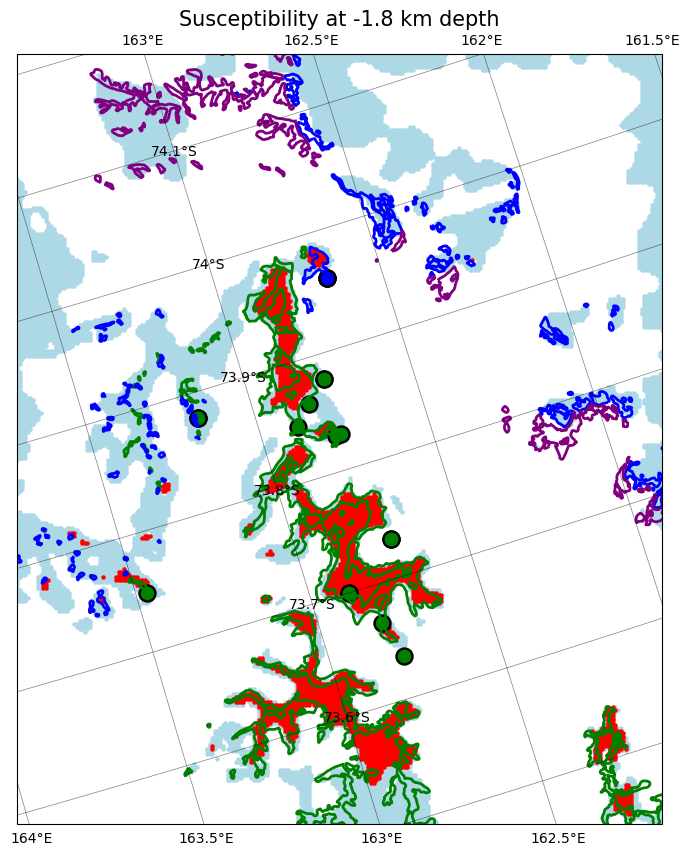

In [28]:
figure1 = plt.figure(figsize=(15, 10), facecolor="white")

ax1 = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())


plt.scatter(
    inv_sus_Ferrar_cliped.Xps,
    inv_sus_Ferrar_cliped.Yps,
    c="lightblue",
    s=5,
    transform=ccrs.SouthPolarStereo(),
)
plt.scatter(
    inv_sus_KPB_clipped.Xps,
    inv_sus_KPB_clipped.Yps,
    c="red",
    s=5,
    transform=ccrs.SouthPolarStereo(),
)


Kirkpatrick_Basalt_geomap.boundary.plot(ax=ax1, color="green", linewidth=2)
ax1.plot([0, 0], "o", color="green", label="Kirkpatrick Basalt")

Ferrar.boundary.plot(ax=ax1, color="blue", linewidth=2)
ax1.plot([0, 0], "o", color="blue", label="Ferrar")

GHI_wsb.boundary.plot(ax=ax1, color="purple", linewidth=2)
ax1.plot([0, 0], "o", color="purple", label="Granite Harbour Intrusives")


NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf.plot(
    ax=ax1, marker="o", color="k", markersize=150, alpha=1
)
NAPA_Kirkpatrick_Basalts_basalt_only_ps_gpdf.plot(
    ax=ax1, marker="o", color="green", markersize=75, alpha=1
)

NAPA_Ferrar_dolerite_only_ps_gpdf.plot(
    ax=ax1, marker="o", color="k", markersize=150, alpha=1
)
NAPA_Ferrar_dolerite_only_ps_gpdf.plot(
    ax=ax1, marker="o", color="blue", markersize=75, alpha=1
)

NAPA_GHI__granite_only_ps_gpdf.plot(ax=ax1, marker="o", color="gray", alpha=1)

plt.title(
    "Susceptibility at {:.1f} km depth".format(Depth_inversion_km[depth_slices_index]), fontsize=15
)

ax1.gridlines(
    linewidth=0.5,
    draw_labels=True,
    color="k",
    alpha=0.5,
    linestyle="-",
    rotate_labels=0,
)

axes = plt.gca()
ax1.set_xlim([507404.438756447, 569404.438756447])
ax1.set_ylim([-1773582.79591434, -1699582.79591434])
# ax1.legend(loc='upper right')
plt.savefig(
    export_fig_path + "rock_classification_with_geo_map_and_rock_location",
    dpi=300,
    facecolor=figure1.get_facecolor(),
    transparent=True,
)